<a href="https://colab.research.google.com/github/rgborges/DataScienceProjects/blob/master/Forecasting_for_Product_Demand_TCC_PUC_Minas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instrodução

## PONTIFÍCIA UNIVERSIDADE CATÓLICA DE MINAS GERAIS

### Pós-graduação Lato Sensu em Ciência de Dados e Big Data

Trabalho de Conclusão de Curso apresentado ao Curso de Especialização em Ciência de Dados e Big Data como requisito parcial à obtenção do título de especialista.


* autor: RAFAEL BORGES BATISTA
* e-mail: rgborges96@gmail.com


# 1. **Importação dos Dados**

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import numpy as np #numpy - biblioteca de manipulação númerica
import pandas as pd #pandas - bibloiteca para manipulação de tabelas

# matplot lib - biblioteca gráfica
# biblioteca para  gráficos 
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
%matplotlib inline



# biblioteca do seaborn
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')

import warnings
import itertools

# comando de importação do ggplot
from plotnine import *
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

# biblioteca de modelos estatísticos
import statsmodels.api as sm

# imporatação teste de Dick Fuller (estacionaridade da série)
from statsmodels.tsa.stattools import adfuller



# Função para calcular as métricas de acurácia do modelo
from statsmodels.tsa.stattools import acf, pacf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(forecast)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#importa dados do csv Historical Product Demand.csv para um dataframe
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Datasets/Forecasting for Product Demand - Kaggle/Historical Product Demand.csv')

# Reindexa o dataframe para começar por 1 em vez de 0
indx = df.index > 0
df = df[indx]
print(df.head(10))

# imprime estruturas do dataframe
print("Dataframe Shape: ", df.shape)
print("Dataframe columns types", df.dtypes)

    Product_Code Warehouse Product_Category       Date Order_Demand
1   Product_0979    Whse_J     Category_028  2012/1/19         500 
2   Product_0979    Whse_J     Category_028   2012/2/3         500 
3   Product_0979    Whse_J     Category_028   2012/2/9         500 
4   Product_0979    Whse_J     Category_028   2012/3/2         500 
5   Product_0979    Whse_J     Category_028  2012/4/19         500 
6   Product_0979    Whse_J     Category_028   2012/6/5         500 
7   Product_0979    Whse_J     Category_028  2012/6/27         500 
8   Product_0979    Whse_J     Category_028  2012/7/23         500 
9   Product_0979    Whse_J     Category_028  2012/8/29         500 
10  Product_0979    Whse_J     Category_028  2012/8/29         500 
Dataframe Shape:  (1048574, 5)
Dataframe columns types Product_Code        object
Warehouse           object
Product_Category    object
Date                object
Order_Demand        object
dtype: object


# 2. **Processamento de Dados e Tratamento dos dados**

Descrição da etapa: Netsa etapa os dados vão ser copiados do dataframe original para um novo dataframe específico para o processamento e tratamento dos dados. Correção destruturais de tipos, remoção de outliers e valores duplicados, transformações básicas, deverão ser feitas nesta sessão.

In [4]:
# tira uma cópia do dataframe de importação
p_df = df.copy()
# imprime a nova estrutura do dataset
print("Dataframe Shape: ", p_df.shape)
print("Dataframe columns types", p_df.dtypes)

Dataframe Shape:  (1048574, 5)
Dataframe columns types Product_Code        object
Warehouse           object
Product_Category    object
Date                object
Order_Demand        object
dtype: object


In [5]:
# converte estrutura de dados do dataframe
p_df['Date'] = pd.to_datetime(p_df['Date']) # converte para Datetime
p_df['Product_Category'] = p_df.Product_Category.astype('category') # converte para categórico
p_df['Product_Code'] = p_df.Product_Code.astype(str) #converte para string
p_df['Warehouse'] = p_df.Warehouse.astype('category') #converte para categórico
# converte o campo Ordem Demand para string, depois remove ( e ) para, no fim, converter a coluna para numérico
p_df['Order_Demand'] = p_df.Order_Demand.astype(str) 
p_df['Order_Demand'] = p_df.Order_Demand.str.replace('(', '')
p_df['Order_Demand'] = p_df.Order_Demand.str.replace(')', '')
p_df['Order_Demand'] = pd.to_numeric(p_df['Order_Demand'])

# imprime a nova estrutura do dataset
print("Dataframe Shape: ", p_df.shape)
print("Dataframe columns types", p_df.dtypes)

Dataframe Shape:  (1048574, 5)
Dataframe columns types Product_Code                object
Warehouse                 category
Product_Category          category
Date                datetime64[ns]
Order_Demand                 int64
dtype: object


In [6]:
# Imprime quantos dados nulos existem em cada coluna
print("Verificação de Dados Nulos:")
print(p_df.isnull().sum())
# Remove os valores nulos do dataset
p_df.dropna()
p_df = p_df[p_df.Date.notnull()]
p_df.reset_index()

print("Valores nulos pós processamento:")
print(p_df[p_df.Date.isnull()].sum())

Verificação de Dados Nulos:
Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64
Valores nulos pós processamento:
Product_Code        0.0
Warehouse           0.0
Product_Category    0.0
Date                0.0
Order_Demand        0.0
dtype: float64


In [0]:
# imprime os valores duplicados
print("Antes")
print(p_df[p_df.duplicated(subset=['Product_Code', 'Product_Category', 'Date', 'Order_Demand'])].count())
# remove valores duplicados
#p_df = p_df.drop_duplicates()
#print("Depois")
#print(p_df[p_df.duplicated(subset=['Product_Code', 'Product_Category', 'Date', 'Order_Demand'])])

Antes
Product_Code        123239
Warehouse           123239
Product_Category    123239
Date                123239
Order_Demand        123239
dtype: int64


In [0]:
# Exporta dados atualizados para outras ferramentas de análise de dados como Qlik Sense
from google.colab import  files
p_df.to_csv('Forecasting_For_Product_Demand_v1.csv')
files.download('Forecasting_For_Product_Demand_v1.csv')

#3. **Exploração e Análise de Dados** 


Descrição da etapa: Nesta estapa, os dados vão passar um processo de Análise Exploratória dos dados. Devem ser vistos dados de distribuição dos valores, features importantes, características dos dados [média, soma, contagem, desvio padrão] e as características temporais da série.

Os dados serão copiados para outro dataframe, é a partir deste que serão feitas as análises.








## 3.1 **Caracteríticas Estatístcas da Série**



In [7]:
# imprime prorpiedades estatísticas do dataset
e_df = p_df.copy()
e_df.describe(include='all')

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
count,1037335,1037335,1037335,1037335,1.037335e+06
unique,2160,4,33,1729,NaN
top,Product_1359,Whse_J,Category_019,2013-09-27 00:00:00,NaN
freq,16936,764446,470266,2075,NaN
first,NaN,NaN,NaN,2011-01-08 00:00:00,NaN
last,NaN,NaN,NaN,2017-01-09 00:00:00,NaN
mean,NaN,NaN,NaN,NaN,4.949388e+03
std,NaN,NaN,NaN,NaN,2.907345e+04
min,NaN,NaN,NaN,NaN,0.000000e+00
25%,NaN,NaN,NaN,NaN,2.000000e+01


Olhando especificamente para a coluna **Order_Demand** vemos uma irregularidade com a dsitribuiçlão dos dados:


*   Desvio Padrão : 2.907 * 10 ^ 3 - 29.073,45
*   Média: 4.949,388
*   Mínimo: 0
*   Máx: 4.0 * 10 ^6 - 4.000.000,00

As demandas apresentam uma distribuição de valores irregular, e nada estável, de forma que a média e o desvio padrão são muito inferiores ao valor máximo de demanda.

Text(0.5, 0, 'Demanda')

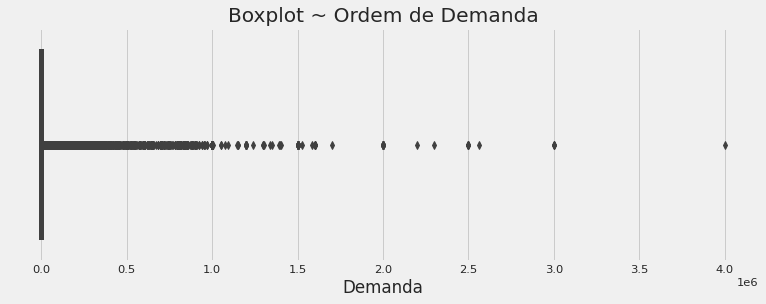

In [8]:
plt.rcParams.update({'figure.figsize':(12,4)})
sns.boxplot(x= e_df['Order_Demand'])
plt.title('Boxplot ~ Ordem de Demanda')
plt.xlabel('Demanda')

In [9]:
#Verifica quantos valores estão acima e abaixo da média
up_mean_filter = e_df['Order_Demand'] > e_df.Order_Demand.mean()
down_mean_filter = e_df['Order_Demand'] < e_df.Order_Demand.mean()
print("Valores acima da média: ", e_df[up_mean_filter].Order_Demand.count(), (e_df[up_mean_filter].Order_Demand.count()/e_df.Order_Demand.count()) * 100, "%")
print("Valores abaixo da média: ", e_df[down_mean_filter].Order_Demand.count(), (e_df[down_mean_filter].Order_Demand.count()/e_df.Order_Demand.count()) * 100, "%")

Valores acima da média:  180341 17.38502990837097 %
Valores abaixo da média:  856994 82.61497009162902 %


Verifica-se que apenas 17,4% dos valores de demanda são maiores que a média e 82,6% abaixo.


Text(0.5, 1.0, 'Histograma - Demanada')

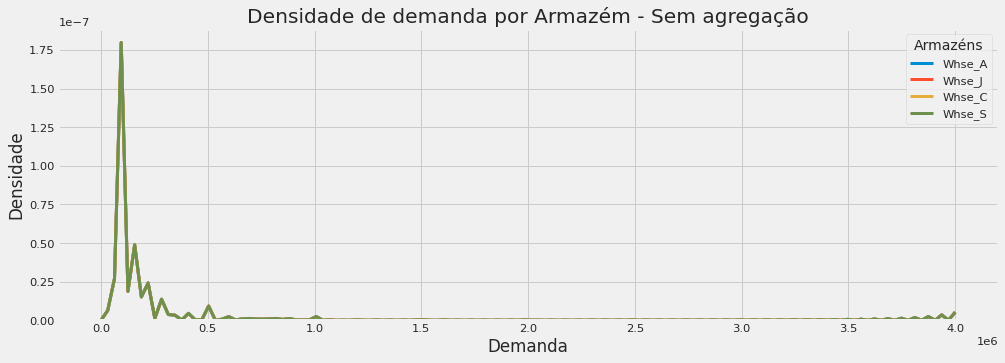

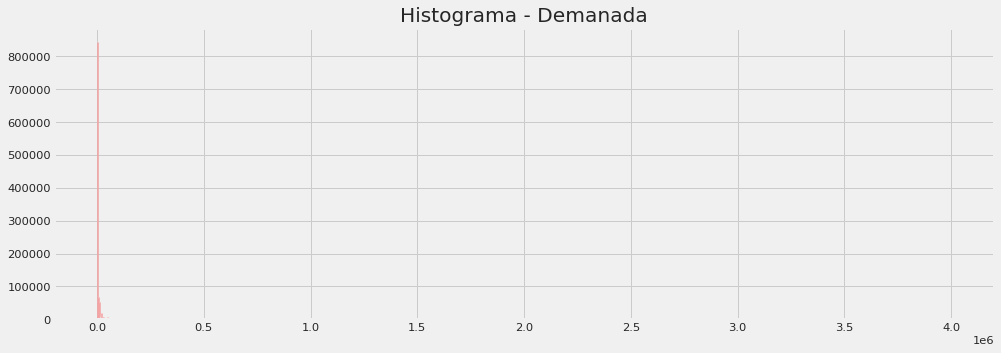

In [10]:
plt.rcParams.update({'figure.figsize':(15,5)})
warehouses = ['Whse_A', 'Whse_J', 'Whse_C', 'Whse_S']

for warehouse in warehouses:
  #Subset de plots
  subset = e_df[e_df['Warehouse'] == warehouse]
  sns.distplot(e_df.Order_Demand, hist = False, kde = True, kde_kws={'linewidth':3}, label=warehouse)

plt.legend(title='Armazéns')
plt.title('Densidade de demanda por Armazém - Sem agregação')
plt.xlabel('Demanda')
plt.ylabel('Densidade')

e_df.hist(bins=1000, color='r')
plt.title('Histograma - Demanada')

Text(0.5, 0, 'Demanda (em uni)')

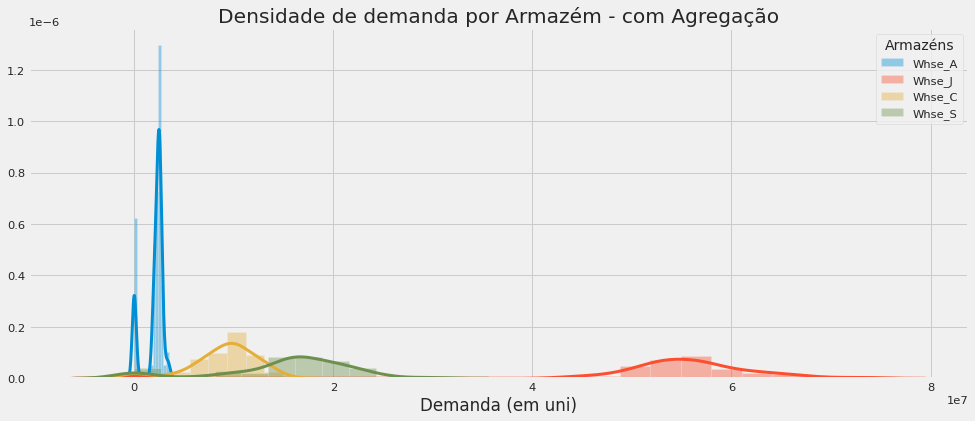

In [11]:
# Plota um gráfico de densidade de demanda por armazem
plt.rcParams.update({'figure.figsize':(15,6)})
warehouses = ['Whse_A', 'Whse_J', 'Whse_C', 'Whse_S']

for warehouse in warehouses:
  #Subset de plots
  subset = e_df[e_df['Warehouse'] == warehouse] #filtra por armazém
  subset = subset.groupby('Date')['Order_Demand'].sum().dropna().reset_index()
  subset = subset.set_index('Date')
  subset = subset.resample('M').sum().dropna()
  sns.distplot(subset['Order_Demand'], hist = True, kde = True, kde_kws={'linewidth':3},norm_hist=True, label=warehouse)

plt.legend(title='Armazéns')
plt.title('Densidade de demanda por Armazém - com Agregação')
plt.xlabel('Demanda (em uni)')



Nota-se que mesmo com a agregação de valores, ainda temos um problema de distribuição e de escala.

Podemos usar uma transformação logarítimica para resolver o problema de variação e escala do dataset e depois verificaros os outliers.

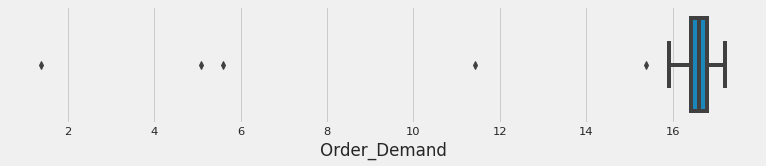

In [12]:
plt.rcParams.update({'figure.figsize':(12,2)})
r = e_df.groupby('Date')['Order_Demand'].sum().dropna().reset_index()
r = r.set_index('Date')
r = r.resample('M').sum().dropna()
r = r[r['Order_Demand'] > 0] # remove os valores zerados - resultam no problema -inf
sns.boxplot(x=np.log(subset['Order_Demand']))

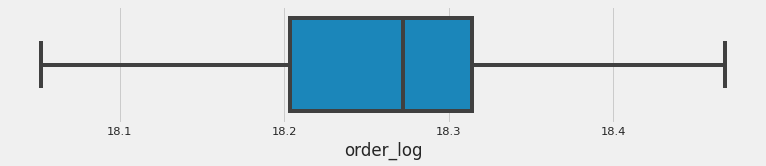

In [13]:
r['order_log'] = np.log(r['Order_Demand'])
outlier_filter = r.order_log < 18.00
r = r[~outlier_filter]
sns.boxplot(x=r.order_log)

Realizando as tranformações acima, de agregação mensal, recebendo o total de cada mês, e utilizando uma transformação logarítimica para ajustar a escala, foi possível identificar os outliers e removê-lo do dataset.

**Sugestões**

* Calcular as probabilidades de cada categoria
*  Calcular as probabilidades de cada produto

## 3.2. **Características Temporais**

In [14]:
# Cópia do dataframe de processessamento em um novo para exploração dos dados
e_df = p_df.copy()
e_df['Year'] = pd.to_datetime(e_df['Date']).dt.year #adição da coluna Ano
e_df['Month'] = pd.to_datetime(e_df['Date']).dt.month # adição da coluna Mês
# implrime os primeiros 5 registros do dataframe de exploração dos dados
print(e_df.head(5))

   Product_Code Warehouse Product_Category  ... Order_Demand  Year  Month
1  Product_0979    Whse_J     Category_028  ...          500  2012      1
2  Product_0979    Whse_J     Category_028  ...          500  2012      2
3  Product_0979    Whse_J     Category_028  ...          500  2012      2
4  Product_0979    Whse_J     Category_028  ...          500  2012      3
5  Product_0979    Whse_J     Category_028  ...          500  2012      4

[5 rows x 7 columns]


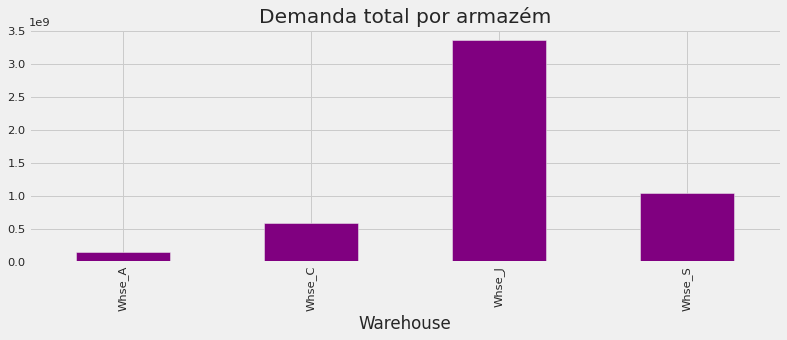

In [15]:
# Imprime a quantidade de valores por armazém
e_df.groupby('Warehouse')['Order_Demand'].sum().plot(kind='bar', color='purple', figsize=(12,4),
                                                      title='Demanda total por armazém')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc945303160>,
      dtype=object)

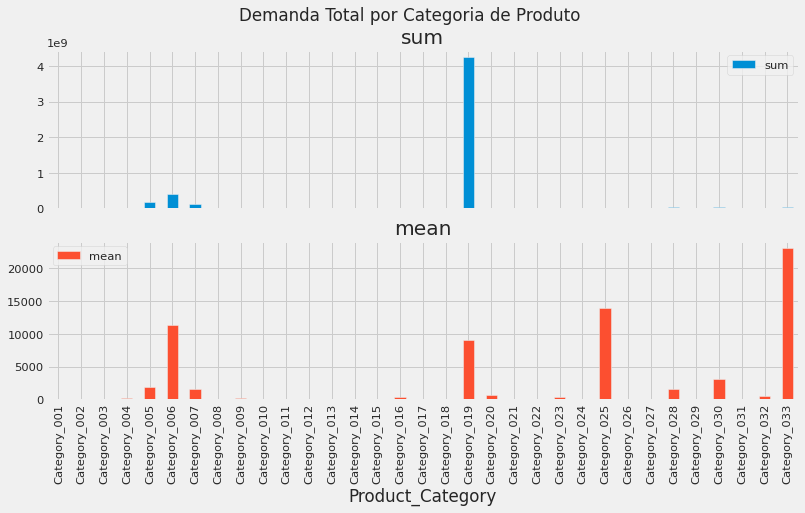

In [16]:
e_df.groupby('Product_Category')['Order_Demand'].agg(['sum', 'mean']).dropna().plot.bar(
    subplots = True,
    figsize=(12, 6), title='Demanda Total por Categoria de Produto')
#plt.tight_layout()

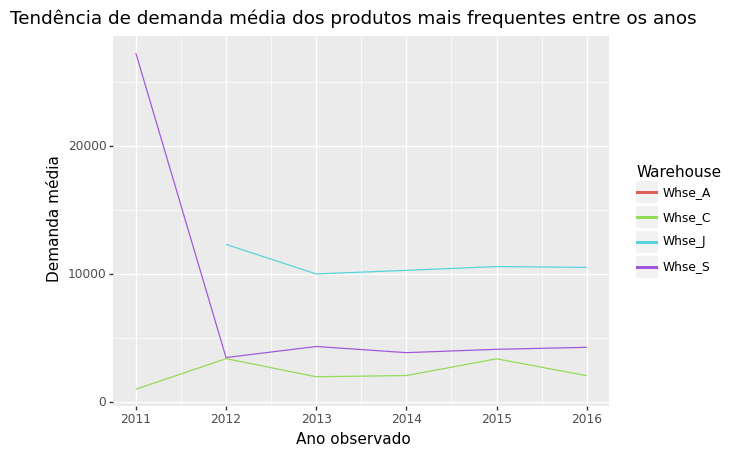

<ggplot: (-9223363255453212935)>

In [17]:
top_categories = ['Category_019, Category_006, Category_005, Category_028',
                  'Category_030', 'Category_033']
r = e_df[e_df.Product_Category.isin(top_categories)]
r = r.groupby(['Year','Warehouse'], as_index= False)['Order_Demand'].mean().dropna()
ggplot(r, aes(x = "Year", y = 'Order_Demand', color='Warehouse')) + \
geom_line() + \
labs(title='Tendência de demanda média dos produtos mais frequentes entre os anos',
     x = 'Ano observado',
     y = 'Demanda média')

Podemos ver que a demanda média desse conjunto de produtos caiu entre 2011 e 2012 para o **armazaém S**. Nota-se também que não se tem valores para o **armazém A** para esse conjunto de produtos.

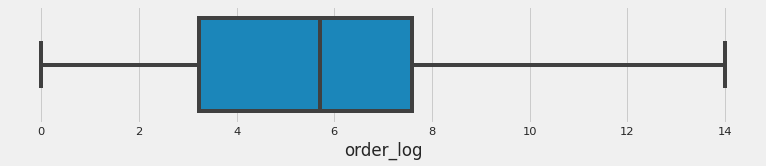

In [18]:
# Remove os outliers em uma escala logarítimica
plt.rcParams.update({'figure.figsize':(12,2)})
adj_df = e_df[e_df['Order_Demand'] > 0]
adj_df['order_log'] =  np.log(adj_df.Order_Demand)
adj_df = adj_df[adj_df['order_log'] < 14.00]
sns.boxplot(x = adj_df.order_log)

In [0]:
e_topcat_df = adj_df[adj_df.Product_Category.isin(top_categories)]
whse_a = e_topcat_df[e_topcat_df['Warehouse'] == 'Whse_A']
whse_j = e_topcat_df[e_topcat_df['Warehouse'] == 'Whse_J']
whse_s = e_topcat_df[e_topcat_df['Warehouse'] == 'Whse_S']
whse_c = e_topcat_df[e_topcat_df['Warehouse'] == 'Whse_C']


#whse a
whse_a = whse_a.groupby('Date')['Order_Demand'].sum().dropna().reset_index()
whse_a = whse_a.set_index('Date')
#whse j
whse_j = whse_j.groupby('Date')['Order_Demand'].sum().dropna().reset_index()
whse_j = whse_j.set_index('Date')
#whse s
whse_s = whse_s.groupby('Date')['Order_Demand'].sum().dropna().reset_index()
whse_s = whse_s.set_index('Date')
#whse_c
whse_c = whse_c.groupby('Date')['Order_Demand'].sum().dropna().reset_index()
whse_c = whse_c.set_index('Date')


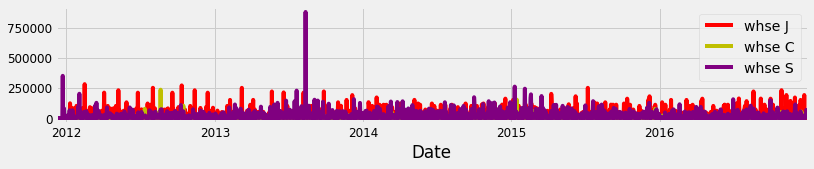

In [0]:
whse_j['Order_Demand'].resample('D').sum().dropna().plot(color='r', legend = True, label='whse J')
whse_c['Order_Demand'].resample('D').sum().dropna().plot(color='y', legend = True, label='whse C')
whse_s['Order_Demand'].resample('D').sum().dropna().plot(color='purple', legend = True, label = 'whse S')
plt.show()

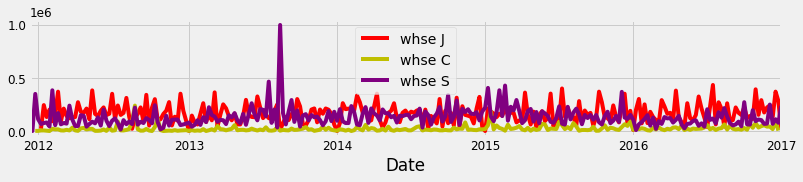

In [0]:
whse_j['Order_Demand'].resample('W').sum().dropna().plot(color='r', legend = True, label='whse J')
whse_c['Order_Demand'].resample('W').sum().dropna().plot(color='y', legend = True, label='whse C')
whse_s['Order_Demand'].resample('W').sum().dropna().plot(color='purple', legend = True, label = 'whse S')
plt.show()

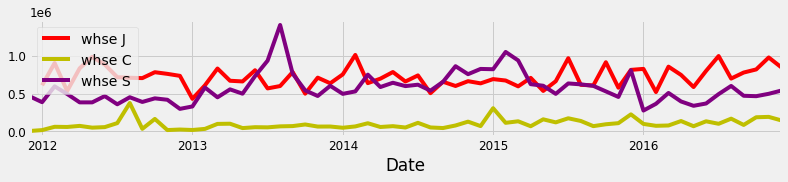

In [0]:
whse_j['Order_Demand'].resample('M').sum().dropna().plot(color='r', legend = True, label='whse J')
whse_c['Order_Demand'].resample('M').sum().dropna().plot(color='y', legend = True, label='whse C')
whse_s['Order_Demand'].resample('M').sum().dropna().plot(color='purple', legend = True, label = 'whse S')
plt.show()

Avançaremos na análise olhando o case dos produtos mais destacados no **Armazém S**.

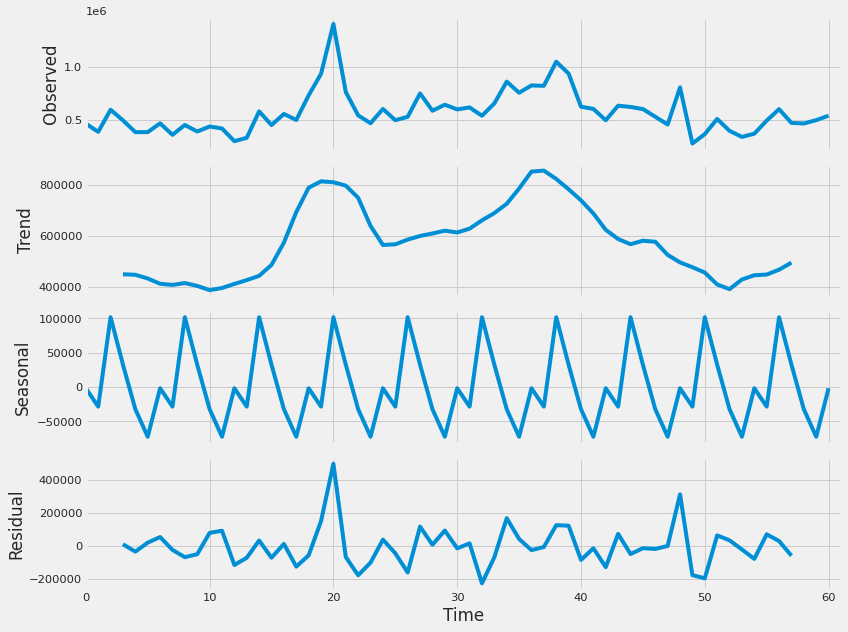

In [20]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 9
y = whse_s['Order_Demand'].resample('M').sum().dropna()
decomposition = sm.tsa.seasonal_decompose(y.values, freq=6, model='additive')
fig = decomposition.plot()
plt.show()

##### **Auto correlação achando o termo (AR)**

A autocorrelação em uma série é o grau a qual um pontos da série se relaciona com os outros pontos do passado (lags). (e.g: grau de relação entre o ponto ***y(t)*** e o ponto ***y(t-1)***). O gráfico acf é uma função completa de auto-correlação a qual retorna o grau de relação de um valor com o seus lags passados.


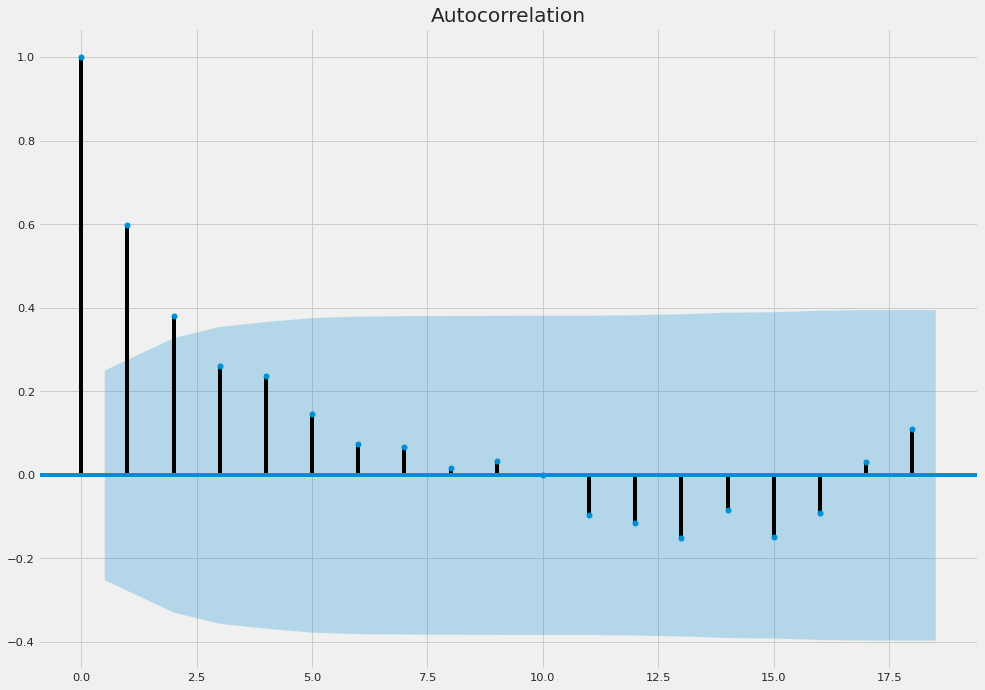

In [21]:
plt.rcParams.update({'figure.figsize':(15,11)})
autocorrelation_diagram = sm.graphics.tsa.plot_acf(y)
plt.show()

Podemos ver com o gráfico acima que pelo menos dois lags possuem relação com um determinado ponto. Neste caso é um termo AR de ordem 3.

##### **Achando o termo de Médias Móveis (MA)**

O termo MA pode ser achado pelo gráfico PACF (Partial Auto Correlation). O PACF é uma função parcial de auto correlação. Em vez de medir a correlação entre os pontos, o PACF mede uma ralação dos resíduos dos pontos (a qual se mantém mesmo depois de remover os efeitos que já são explicados em lags anteriores). 


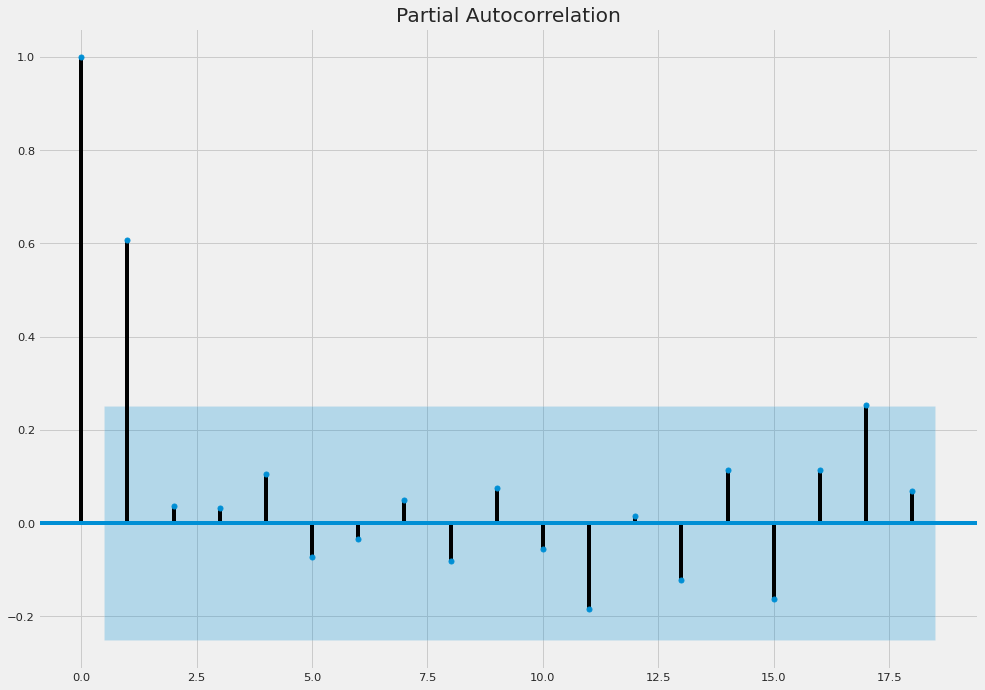

In [22]:
pautocorrelation_diagram = sm.graphics.tsa.plot_pacf(y)
plt.show()

De acordo com o gráfico acima, o termo MA é 2.



#### **Estacionarudade da Série**

Os resultados obtidos acima sugerem que os valores ainda possuem uma dependência entre si, em outras palavras, sugere que a série não é estacionária. 

É possível aplicarmos o método de diferenciação da séria para estacionarizá-la e podemos aproveitar para estabilizar a escala da série aplicando a função log nos valores de demanda.

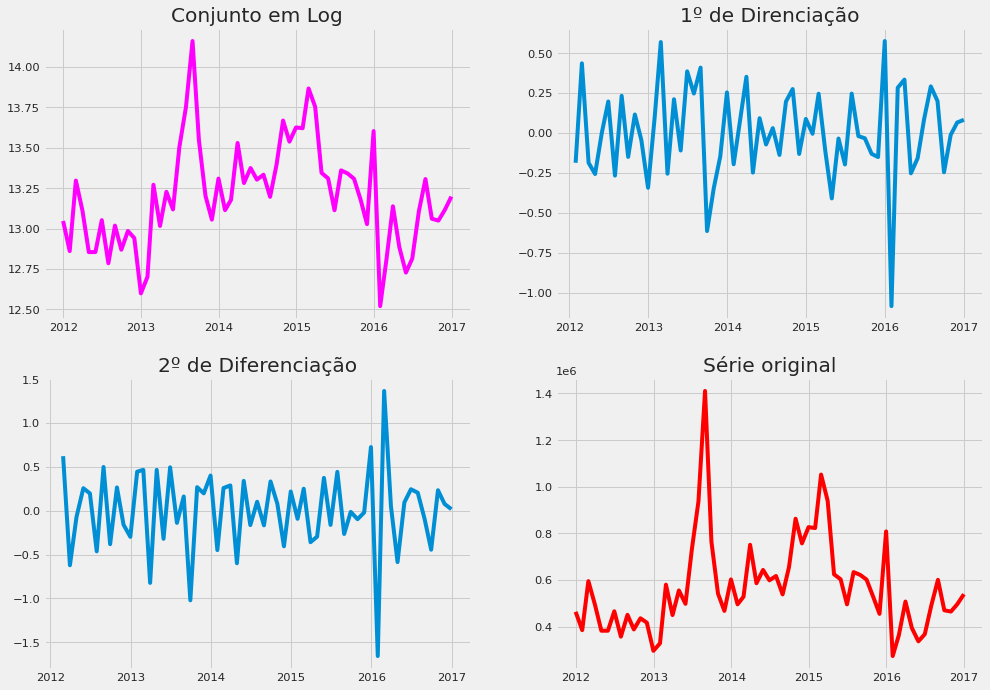

In [23]:
#Imprime a série em log, com 1 diferenciação e 2 diferenciação
plt.rcParams.update({'figure.figsize':(15,11)})
fig, ax = plt.subplots(2,2)

y_log = np.log(y)
y_log = y_log.dropna()
y_log_d1 = y_log.diff().dropna()
y_log_d2 = y_log.diff().diff().dropna()

ax[0][0].plot(y_log, color='magenta')
ax[0][0].set_title('Conjunto em Log')
ax[0][1].plot(y_log_d1)
ax[0][1].set_title('1º de Direnciação')
ax[1][0].plot(y_log_d2)
ax[1][0].set_title('2º de Diferenciação')
ax[1][1].plot(y, color='r')
ax[1][1].set_title('Série original')

plt.show()

O teste de Dock Fuller testa se uma série é estacionária ou não, podemos analizar pelo valor p que represente o teste de hipótese da série ser estacionária. A hipótese H0 ou nula do teste é da série ser não estacionária enquanto H1 siginifica que a série é estacionária. Então se o valor p for menor que p o níve de significância (0.05), então podemos rejeitar H0 e assumir que a série é estacionária.

Caso o valor seja maior, precisamos usar outra maneira de transformação da série a fim de deixá-la estacionária.

In [24]:
from statsmodels.tsa.stattools import adfuller
results = [adfuller(y), adfuller(y_log), adfuller(y_log_d1), 
           adfuller(y_log_d2)]

for result in results:
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -3.829467
p-value: 0.002620
Critical Values:
	1%: -3.544
	5%: -2.911
	10%: -2.593
ADF Statistic: -3.811896
p-value: 0.002788
Critical Values:
	1%: -3.544
	5%: -2.911
	10%: -2.593
ADF Statistic: -7.628779
p-value: 0.000000
Critical Values:
	1%: -3.548
	5%: -2.913
	10%: -2.594
ADF Statistic: -7.497313
p-value: 0.000000
Critical Values:
	1%: -3.555
	5%: -2.916
	10%: -2.596


Com os resultados dos testes acima, podemos ver que a série em si já estacionária, porém a deferenciando uma vez exibe resultados melhores.

Os testes ADF, KPSS, PP indicam quatas diferenciações são necessárias para estacionarizar a série.

In [0]:
pip install pmdarima

     |████████████████████████████████| 1.5MB 2.8MB/s 


In [0]:
from pmdarima.arima.utils import ndiffs
#teste Adf 
print(ndiffs(y_log.values, test='adf'))

#teste KPSS
print(ndiffs(y_log.values, test='kpss'))

#teste PP
print(ndiffs(y_log.values, test='pp'))


Desta forma podemos assumir pelo menos **uma** diferenciação na série para torná-la estacionária.

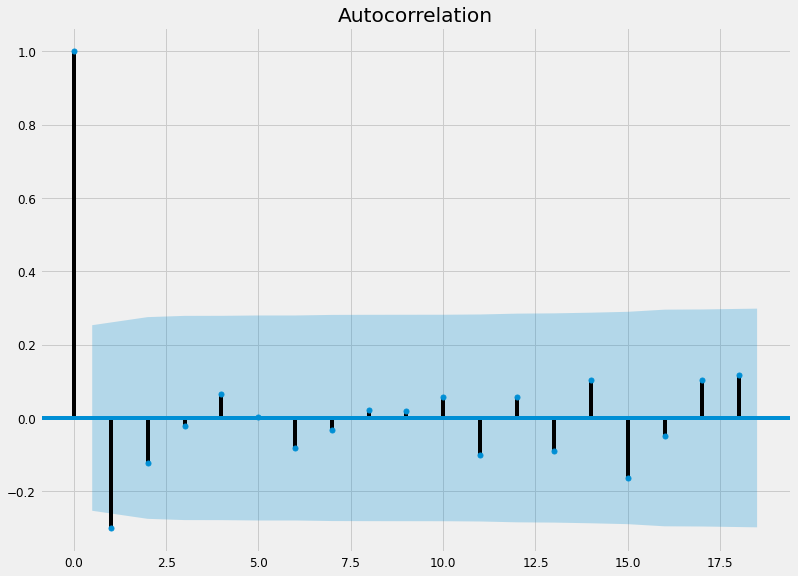

In [0]:
autocorrelation_diagram = sm.graphics.tsa.plot_acf(y_log_d1)
plt.show()

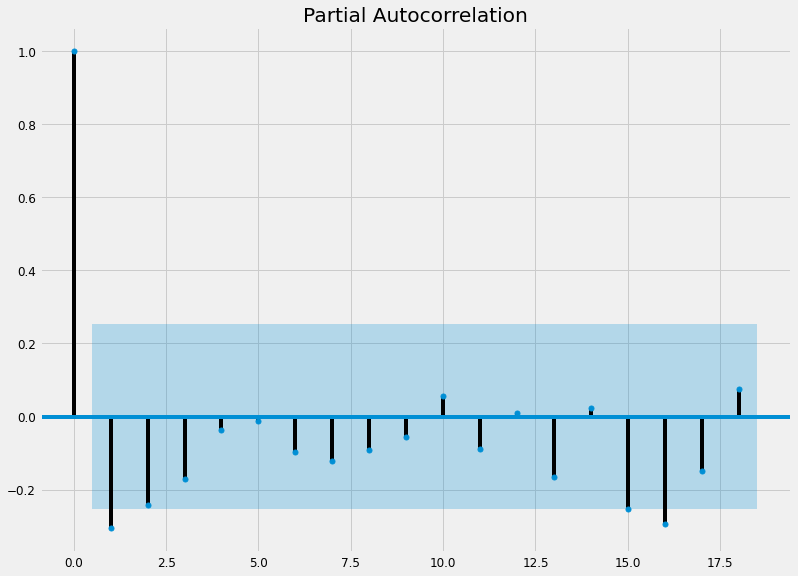

In [0]:
pautocorrelation_diagram = sm.graphics.tsa.plot_pacf(y_log_d1)
plt.show()

## 3.3 Predição mensal usando o modelo ARIMA, SARIMA, SARIMAX

In [0]:
#Separa base de treinamento e base de teste
train = y_log[:'2016-05-30']
test = y['2016-06-30':'2016-12-31']

print(train.shape, test.shape, y.shape)

(53,) (7,) (61,)


In [0]:
y_values = y.values
y_log_values = y_log.values
y_train_size = int(len(y_log_values) * 0.80)
y_test_size = len(y_log_values) - y_train_size
train= y_log[:y_train_size]
test = y[y_train_size + 1:]

print(train.shape, test.shape, y.shape)

(48,) (12,) (61,)


In [0]:
print(train)
print(test)

#### 3.3.1 **Modelo ARIMA**

De acordo com os testes realizados acima com o Dick Fuller, PACF e ACF, usaremos os seguintes parâmetroa para o modelo:

* AR = 3
* MA = 2
* I = 0, pois vimos que a série por sí só pode ser considerada estacionária.

In [0]:
from statsmodels.tsa.arima_model import ARIMA

y_ARIMA_model = ARIMA(train, order=(3,0,2))
y_ARIMA_model_fit = y_ARIMA_model.fit(disp=0)
print(y_ARIMA_model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:           Order_Demand   No. Observations:                   53
Model:                     ARMA(3, 2)   Log Likelihood                  -2.836
Method:                       css-mle   S.D. of innovations              0.247
Date:                Mon, 06 Apr 2020   AIC                             19.672
Time:                        21:00:55   BIC                             33.464
Sample:                    12-31-2011   HQIC                            24.976
                         - 04-30-2016                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 13.2055      0.092    143.925      0.000      13.026      13.385
ar.L1.Order_Demand     0.1935      0.136      1.423      0.161      -0.073       0.460
ar.L2.Order_Demand  

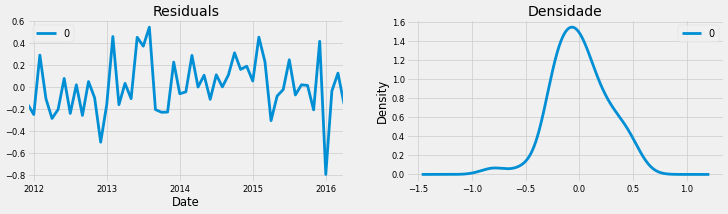

In [0]:
plt.rcParams.update({'figure.figsize':(16,4),'figure.dpi':50})
residuals = pd.DataFrame(y_ARIMA_model_fit.resid)

fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax = ax[0])
residuals.plot(kind='kde', title="Densidade", ax = ax[1])

plt.show()

In [0]:
print(residuals.describe(include='all'))

               0
count  53.000000
mean    0.002947
std     0.256599
min    -0.797251
25%    -0.160042
50%    -0.002429
75%     0.157614
max     0.541953


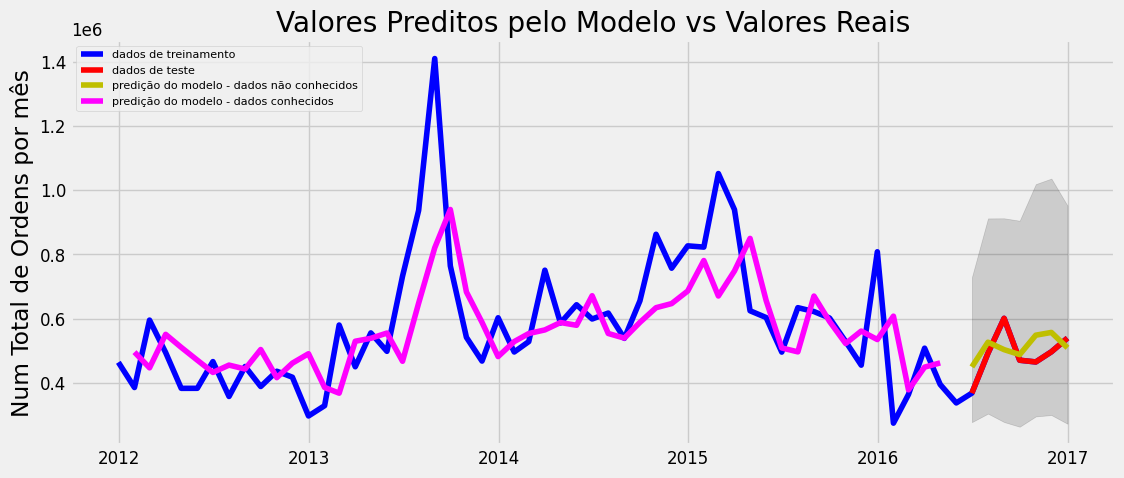

In [0]:
# Constrói o modelo
fitted = y_ARIMA_model_fit  

# Predição
fc, se, conf = fitted.forecast(7, alpha=0.05)  # 95% conf

# Transforma em uma série pandas
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
lower_series = np.exp(lower_series) # converte para escala original
upper_series = np.exp(upper_series) # converte para escala original

#
a = y_ARIMA_model_fit.predict(start='2012-01-31', dynamic=False)

# Plotagem do gráfico
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y, label='dados de treinamento', color='b')
plt.plot(test, label='dados de teste', color='r')
plt.plot(np.exp(fc_series), label='predição do modelo - dados não conhecidos', color='y')
plt.plot(np.exp(a), color='magenta', label='predição do modelo - dados conhecidos')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Valores Preditos pelo Modelo vs Valores Reais')
plt.ylabel('Num Total de Ordens por mês')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [0]:
#Extraí os resultados de predição
results = y_ARIMA_model_fit  
fc, se, conf = results.forecast(7, alpha=0.05)
fc_series = pd.Series(fc, index=test.index)
y_ARIMA_pred = np.exp(fc_series)
y_ARIMA_pred

#### **Como saber se este é o melhor modelo?**

Obtivemos o resultado acima porém como saber se os parâmetros para este modelo são os melhores? Podemos utilizar o modelo AUTO ARIMA para verificar os melhores parâmetros para o modelo. O auto arima utiliza uma técnica de ***cross validations*** dos parâmetros e seleciona o modelo de menor AIC.

In [0]:
pip install pmdarima

In [0]:
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm


model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # usa o teste 'adf' para achar o melhor termo 'd'
                      max_p=3, max_q=3, # máximo valot de p e q
                      m=11,              # frequência da série
                      d=None,           # Deixa o modelo determinar a ordem 'd'
                      seasonal=False,   # Sem sazonalidade
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=19.496, BIC=27.301, Time=0.117 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=25.456, BIC=29.359, Time=0.021 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=21.410, BIC=27.263, Time=0.032 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=18.355, BIC=24.209, Time=0.055 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=23.462, BIC=25.413, Time=0.009 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=19.664, BIC=27.469, Time=0.077 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=20.195, BIC=29.951, Time=0.414 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Total fit time: 0.735 seconds
                           Statespace Model Results                           
Dep. Variable:                 

In [0]:
model.fit(train)

ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

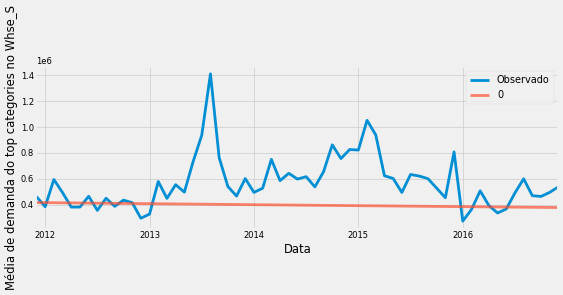

In [0]:
pred = model.predict(n_periods=61)
pred_ci = model.conf_int()
pred_ci = np.exp(pred_ci)
ax = y.plot(label='Observado')
pred_exp = np.exp(pred)
pred_exp = pd.DataFrame(pred_exp, index=y.index)
pred_exp.plot(ax=ax, label='Forecast', alpha=.7, figsize=(12,4))


ax.set_xlabel('Data')
ax.set_ylabel('Média de demanda do top categories no Whse_S')
plt.legend()

plt.show()

In [0]:
y_AUTO_ARIMA_pred =  model.predict(n_periods=7)
y_AUTO_ARIMA_pred = np.exp(y_AUTO_ARIMA_pred)
y_AUTO_ARIMA_pred

array([417193.66378187, 416521.89078296, 415851.19948543, 415181.5881475 ,
       414513.0550302 , 413845.59839737, 413179.21651563])

#### 3.3.2. **Modelo SARIMAX**

In [0]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [0]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
          mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
          results = mod.fit()
          print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
          continue

Vamos utilizar a linha ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:15.57579493347898

In [0]:
y_sarima_model = sm.tsa.statespace.SARIMAX(train, 
                                       order=(0,1,1),
                                       seasonal_order=(0,0,0,12),
                                       enforce_stationary=False,
                                       enforce_invertibility=False)

y_sarima_model_results = y_sarima_model.fit()
print(y_sarima_model_results.summary())

                           Statespace Model Results                           
Dep. Variable:           Order_Demand   No. Observations:                   53
Model:               SARIMAX(0, 1, 1)   Log Likelihood                  -6.181
Date:                Sun, 05 Apr 2020   AIC                             16.362
Time:                        22:50:12   BIC                             20.265
Sample:                    12-31-2011   HQIC                            17.858
                         - 04-30-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4911      0.104     -4.711      0.000      -0.695      -0.287
sigma2         0.0739      0.012      5.987      0.000       0.050       0.098
Ljung-Box (Q):                       28.67   Jarque-

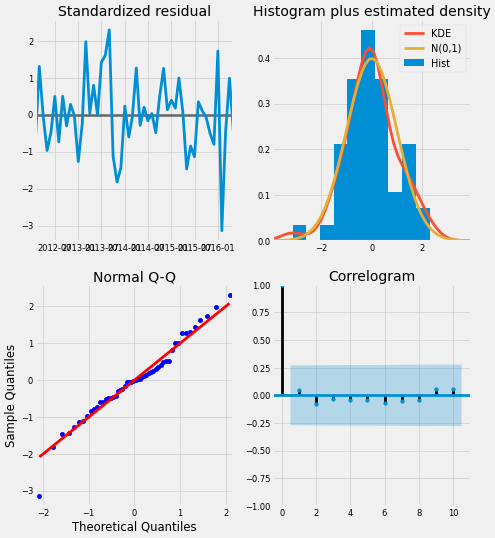

In [0]:
y_sarima_model_results.plot_diagnostics(figsize=(10,12))
plt.show()

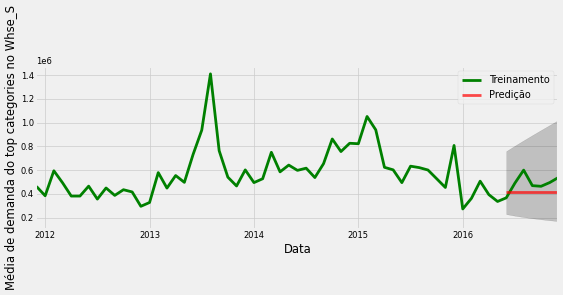

In [0]:
pred = y_sarima_model_results.get_prediction(
    start=pd.to_datetime('2016-06-30'),
    end=pd.to_datetime('2016-12-31'),
    dynamic = False)
pred_ci = pred.conf_int()
pred_ci = np.exp(pred_ci)
ax = y.plot(label='Treinamento', color='g')
pred_exp = pred.predicted_mean
pred_exp = np.exp(pred_exp)
pred_exp.plot(ax=ax, label='Predição', alpha=.7, color='r', figsize=(12,4))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Data')
ax.set_ylabel('Média de demanda do top categories no Whse_S')
plt.legend()

plt.show()

In [0]:
#Extraír resultados do modelo SARIMAX
pred = y_sarima_model_results.get_prediction(start=pd.to_datetime('2016-06-30'), end=pd.to_datetime('2016-12-31'), dynamic = False)
y_SARIMAX_pred = pred.predicted_mean
y_SARIMAX_pred = np.exp(y_SARIMAX_pred)
print(y_SARIMAX_pred.shape)

(7,)


### 3.3.3. **Avaliando a Performance do Modelo**



In [0]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

In [0]:
forecast_accuracy(y_ARIMA_pred, test)

{'acf1': -0.05134918815934151,
 'corr': 0.4067215275620075,
 'mae': 57897.48205506687,
 'mape': 0.12134602740289237,
 'me': 21360.349229219104,
 'minmax': 0.10892767110211943,
 'mpe': 0.058877728304656755,
 'rmse': 64623.89663669502}

In [0]:
forecast_accuracy(y_SARIMAX_pred, test)

{'acf1': -0.05134918815934151,
 'corr': -1.2541312898865109e-16,
 'mae': 86062.58909502956,
 'mape': 0.1686363556968929,
 'me': -71459.05330446996,
 'minmax': 0.1662091497304372,
 'mpe': -0.12888802747000233,
 'rmse': 97481.30104934546}

In [0]:
forecast_accuracy(y_AUTO_ARIMA_pred, test)

{'acf1': -0.05134918815934151,
 'corr': -0.4177072059983788,
 'mae': 89014.44506039747,
 'mape': 0.17433375420969183,
 'me': -74787.68397986231,
 'minmax': 0.17202289615710697,
 'mpe': -0.1356109423410605,
 'rmse': 100326.05750965941}

## 3.4. **Modelo LSTM**

Para a etapa de machine learning vamos usar um método de deep learning com o algorítimo LSTM. O LSTM é um modelo de rede neural recorrente e é main indicado para casos de time series.


In [30]:
#Importação das dependências v1 tensorflow 
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np


import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
%matplotlib inline

import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time

from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf

import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping







Using TensorFlow backend.


In [0]:
#Importação das dependências v2 do tensorflow 
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy import stats

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 16, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


#### **Prepara os dados para o modelo LTSM**

In [0]:
# Recebe um cópia dos valores origininais sa série
# y - total de ordens por mês em cada ano
y_ml = y.values
y_ml = y_ml.reshape(-1, 1)
# Normaliza o dataset reajustando a scala dos dados de 0 à 1
scaler = MinMaxScaler(feature_range=(0,1))
y_ml_scaled = scaler.fit_transform(y_ml)

# Usa a função series_to_supervised para arrranjar os dados
# em uma estrutura supervisionada, onde t-1 define t.
y_ml_reframed = series_to_supervised(y_ml_scaled, 1, 1)

# Inprime y_ml arranjado para um problema supervisioando
print(y_ml_reframed)

#### **Define base de treinamento e de teste**

In [0]:
# Atualiza y_ml com os valores rajustados
y_ml = y_ml_reframed.values

# Define tamanho da base de treinamento e de test
#y_ml_train_size = int(len(y_ml) * 0.80)
y_ml_train_size = int(len(y_ml) * 0.89)
y_ml_test_size = len(y_ml) - y_ml_train_size
print("Tamanho da base de teste:", y_ml_test_size)
print("Tamanho da base de treinamento:", y_ml_train_size)

train= y_ml[:y_ml_train_size, :]
test = y_ml[y_ml_train_size:, :]
print(train.shape)
print(test.shape)

Tamanho da base de teste: 7
Tamanho da base de treinamento: 53
(53, 2)
(7, 2)


In [0]:
# Divide base de treinamento e de teste entre entrada e saída
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# formata a entrada para ser uma array 3D [amostras, timestamps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(53, 1, 1) (53,) (7, 1, 1) (7,)


Os dados foram formatados em um array 3D para estar de acordo com o input exigido pelo modelo LTSM.

In [0]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
  units=128,
  input_shape=(train_X.shape[1], train_X.shape[2])
))
model.add(keras.layers.Dense(units=1))
model.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

In [0]:
history = model.fit(
    train_X, train_y,
    epochs=200,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)
model.summary()

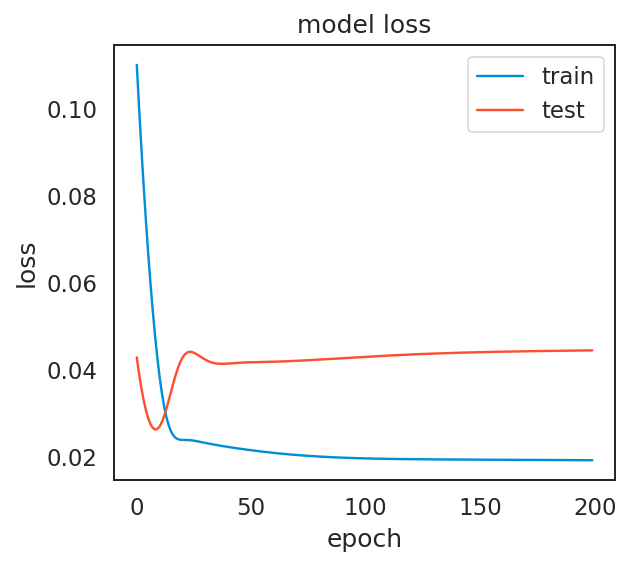

In [0]:
# Resume o histórico de perdas do modelo
plt.rcParams.update({'figure.figsize':(4,4)})
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

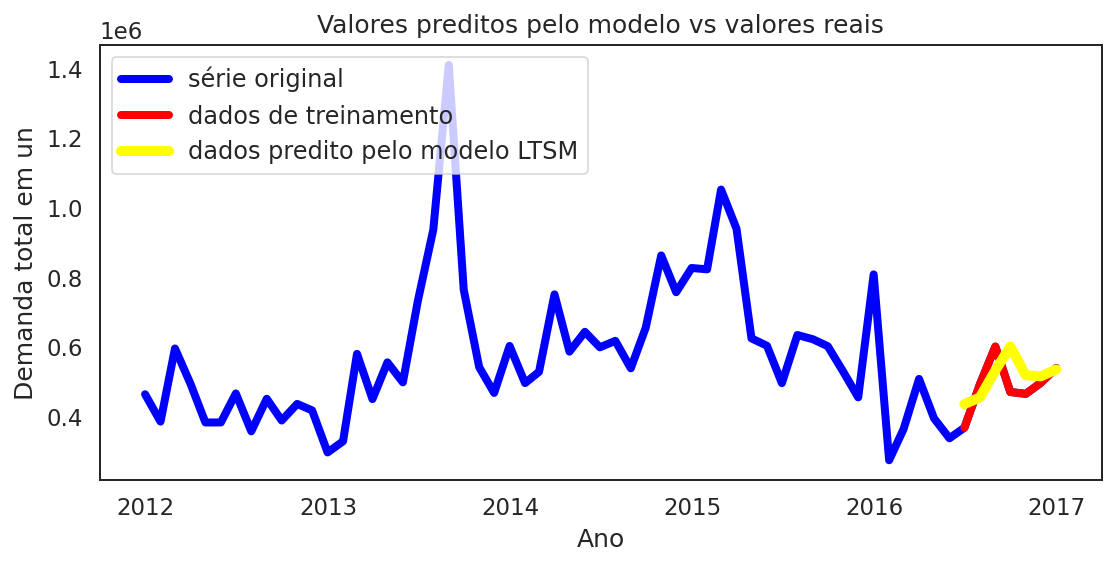

In [0]:
plt.rcParams.update({'figure.figsize':(8,4)})

# Imprime forecasts
train_r = y['2016-06-30': '2016-12-31']

# Seleciona predições do modelo
y_pred = model.predict(test_X)
y_pred = scaler.inverse_transform(y_pred) 
y_pred = y_pred.reshape(1, -1)
y_pred = y_pred[0]
y_pred = pd.Series(y_pred, index=train_r.index)

fig, ax = plt.subplots()

ax.plot(y, label='série original', color='blue', linewidth=4)
ax.plot(train_r, label='dados de treinamento', color='red', linewidth=4)
ax.plot(y_pred, label='dados predito pelo modelo LTSM', color='yellow', linewidth=5)

plt.title('Valores preditos pelo modelo vs valores reais')
plt.xlabel('Ano')
plt.ylabel('Demanda total em un')
plt.legend(loc='upper left', fontsize=12)
plt.show()

In [0]:
forecast_accuracy(y_pred, train_r)

{'acf1': 0.3128465535824149,
 'corr': 0.45511718282841923,
 'mae': 54491.763392857145,
 'mape': 0.1163806397611465,
 'me': 22940.397321428572,
 'minmax': 0.10172084437340823,
 'mpe': 0.05967128479835014,
 'rmse': 66596.9515388316}